## See BJA-0.1.1 for source of this code

In [2]:
import json
import importlib
import os
import sys
import xml
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from src.utils import parse_lipid, parse_p_value, tight_bbox
from src.plots import plot_quant_vs_ogtt
import src.Fig4_subplots
# importlib.reload(plots)

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm
import seaborn as sns
# plt.rcParams['text.usetex'] = False
plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

plt.rcParams['font.size'] = 6
plt.rcParams['axes.labelsize'] = 6

In [3]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# `Melt` the animal phenotypes df `ap` into long-form for each data type used in a phenotype plot

In [4]:
ap

,sex,cohort,Nile rat label,Date of birth,litter,original,validation,lcms_sampled,glucose_tolerance,OGTT_age,...,Weightprefastweek12,HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes
animal,,,,,,,,,,,,,,,,,,,,,
1060,M,10wk,G,2021-01-23,0.0,True,False,True,impaired,12.0,...,105.1,NaN,2.0448,1.945576,0.7185,0.683635,2.845929,murky,No,NaN
1061,M,10wk,NaN,2021-01-23,0.0,False,True,True,NaN,12.0,...,101.7,NaN,1.7808,1.751032,0.6059,0.595772,2.939099,murky,Slight,NaN
1062,M,10wk,E,2021-01-23,0.0,True,False,True,impaired,12.0,...,109.1,NaN,2.5185,2.308433,0.7439,0.681852,3.385536,murky,No,NaN
1063,M,10wk,NaN,2021-01-23,0.0,False,False,False,NaN,NaN,...,109.2,NaN,2.5485,2.333791,0.8614,0.788828,2.958556,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
1074,M,10wk,D,2021-01-23,0.0,True,False,True,impaired,12.0,...,110.4,NaN,2.5060,2.269928,0.7164,0.648913,3.498046,murky,Slight,NaN
1075,M,10wk,NaN,2021-01-23,0.0,False,True,True,NaN,12.0,...,105.5,NaN,1.3107,1.242370,0.5910,0.560190,2.217766,White,Yes,NaN
1076,M,10wk,J,2021-01-23,0.0,True,False,True,diabetic,12.0,...,112.1,NaN,1.4332,1.278501,0.6960,0.620874,2.059195,White,Slight,NaN
1080,M,10wk,NaN,2021-01-24,1.0,False,False,False,NaN,NaN,...,112.1,NaN,1.9369,1.727832,0.7754,0.691704,2.497937,NaN,No,OGTT failed Didn't collect tissue or post-OGTT...
1081,M,10wk,NaN,2021-01-24,1.0,False,True,True,NaN,12.0,...,113.2,NaN,1.3511,1.193551,0.6283,0.555035,2.150406,White,No,NaN


In [7]:
ap.loc[ap['original']]

,sex,cohort,Nile rat label,Date of birth,litter,original,validation,lcms_sampled,glucose_tolerance,OGTT_age,...,HbA1c,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,Plasma,Fatty liver,Notes,ogtt_rank
animal,,,,,,,,,,,,,,,,,,,,,
1060,M,10wk,G,2021-01-23,0.0,True,False,True,impaired,12.0,...,NaN,2.0448,1.945576,0.7185,0.683635,2.845929,murky,No,NaN,22.0
1062,M,10wk,E,2021-01-23,0.0,True,False,True,impaired,12.0,...,NaN,2.5185,2.308433,0.7439,0.681852,3.385536,murky,No,NaN,17.0
1074,M,10wk,D,2021-01-23,0.0,True,False,True,impaired,12.0,...,NaN,2.5060,2.269928,0.7164,0.648913,3.498046,murky,Slight,NaN,8.0
1076,M,10wk,J,2021-01-23,0.0,True,False,True,diabetic,12.0,...,NaN,1.4332,1.278501,0.6960,0.620874,2.059195,White,Slight,NaN,27.0
1082,M,10wk,I,2021-01-24,1.0,True,False,True,diabetic,12.0,...,NaN,0.8904,0.818382,0.6515,0.598805,1.366692,White,Yes,NaN,24.0
1091,M,10wk,A,2021-01-31,2.0,True,False,True,normal,12.0,...,NaN,1.4930,1.615801,0.5354,0.579437,2.788569,clear,Slight,NaN,1.0
1092,M,10wk,C,2021-01-31,2.0,True,False,True,impaired,12.0,...,NaN,1.2902,1.312513,0.6312,0.642116,2.044043,clear,Slight,NaN,7.0
1093,M,10wk,B,2021-01-31,2.0,True,False,True,normal,12.0,...,NaN,1.1374,1.203598,0.5462,0.577989,2.082387,clear,Yes,NaN,3.0
1101,M,10wk,H,2021-02-01,3.0,True,False,True,diabetic,12.0,...,NaN,0.9262,0.838190,0.6216,0.562534,1.490026,murky,Yes definitely,NaN,23.0


In [10]:
df

,RBGweek4,RBGweek8,RBGweek9,RBGweek10,RBGweek11,RBGweek12,RBGweek20,RBGweek21,RBGweek22,RBGweek23,...,RBGweek25,RBGweek26,RBGweek27,RBGweek28,RBGweek29,RBGweek30,RBGweek31,RBGweek32,RBGweek33,RBGweek34
animal,,,,,,,,,,,,,,,,,,,,,
1060,71.0,225.000000,83.000000,206.0,221.0,193.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1062,78.0,256.500000,250.500000,139.5,248.5,90.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1074,70.0,232.500000,203.500000,205.5,225.5,139.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1076,96.0,387.666667,281.000000,349.0,391.5,435.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082,90.0,272.000000,339.500000,330.5,413.0,537.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1091,84.0,108.500000,86.000000,71.5,78.0,68.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1092,75.0,76.000000,70.500000,59.0,58.0,44.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1093,72.0,82.000000,83.000000,69.5,65.5,65.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1101,73.0,459.500000,342.666667,352.0,505.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
col_names

[4, 8, 9, 10, 11, 12]

In [14]:
ap.loc[ap['original'], 'ogtt_rank'] = ap.loc[ap['original'], 'OGTT (AUC)'].rank()
dfs = {}
for regex_str, data_name, col_names, cols_to_keep in [
    ('^RBG', 'RBG', [4, 8, 9, 10, 11, 12], [8, 9, 10]),
    ('^FBG', 'FBG', [8, 9, 10, 11, 12], [8, 9, 10]),
    ('Weightprefast', 'weight', [8, 9, 10, 11, 12], [8, 9, 10, 11, 12]),
    ('OGTT\(', 'OGTT',   [0, 10, 20, 30, 60, 120], [0, 10, 20, 30, 60, 120]),
    ('Insulin\(', 'ITT', [0, 10, 20, 30, 60, 120], [0, 10, 20, 30, 60, 120]),
    ('InsulinRBG', 'Rinsulin', [8, 9, 10, 11, 12], [8, 9, 10]),
    ('InsulinFBG', 'Finsulin', [8, 9, 10, 11, 12], [8, 9, 10]),
    ]:
    print(data_name)
    df = ap.loc[(ap['original']) & (~ap['validation']), 
                ap.filter(regex=regex_str).columns]
    display(df)
    df = df.iloc[:, :len(col_names)]
    df.columns = col_names
    df = df.loc[:, cols_to_keep]
    df = df.melt(var_name='x', value_name='y', ignore_index=False).reset_index()
    df['dummy'] = 'dummy'
    df['gluc_tol'] = df['animal'].map(ap['glucose_tolerance'])
    df['ogtt_rank'] = df['animal'].map(ap['ogtt_rank'])
    df = df.sort_values('gluc_tol', ascending=False)
    display(df)
    dfs[data_name] = df

RBG


,RBGweek4,RBGweek8,RBGweek9,RBGweek10,RBGweek11,RBGweek12,RBGweek20,RBGweek21,RBGweek22,RBGweek23,...,RBGweek25,RBGweek26,RBGweek27,RBGweek28,RBGweek29,RBGweek30,RBGweek31,RBGweek32,RBGweek33,RBGweek34
animal,,,,,,,,,,,,,,,,,,,,,
1060,71.0,225.000000,83.000000,206.0,221.0,193.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1062,78.0,256.500000,250.500000,139.5,248.5,90.333333,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1074,70.0,232.500000,203.500000,205.5,225.5,139.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1076,96.0,387.666667,281.000000,349.0,391.5,435.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1082,90.0,272.000000,339.500000,330.5,413.0,537.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1091,84.0,108.500000,86.000000,71.5,78.0,68.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1092,75.0,76.000000,70.500000,59.0,58.0,44.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1093,72.0,82.000000,83.000000,69.5,65.5,65.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1101,73.0,459.500000,342.666667,352.0,505.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,86.000000,dummy,normal,1.0
27,1093,10,69.500000,dummy,normal,2.0
25,1091,10,71.500000,dummy,normal,1.0
5,1091,8,108.500000,dummy,normal,1.0
7,1093,8,82.000000,dummy,normal,2.0
17,1093,9,83.000000,dummy,normal,2.0
1,1062,8,256.500000,dummy,impaired,5.0
26,1092,10,59.000000,dummy,impaired,3.0
22,1074,10,205.500000,dummy,impaired,4.0
21,1062,10,139.500000,dummy,impaired,5.0


FBG


,FBGweek8,FBGweek9,FBGweek10,FBGweek11,FBGweek12
animal,,,,,
1060,41.000000,48.000000,52.500000,50.0,58.5
1062,52.333333,48.000000,40.000000,38.5,56.5
1074,171.333333,51.500000,55.000000,46.0,38.5
1076,174.333333,78.500000,71.000000,50.5,138.0
1082,59.000000,53.333333,50.000000,73.5,62.0
1091,53.333333,63.000000,48.500000,63.0,72.0
1092,46.000000,63.500000,51.500000,60.0,59.5
1093,47.000000,64.000000,56.500000,56.5,50.0
1101,40.750000,43.000000,44.500000,66.5,64.5


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,63.000000,dummy,normal,1.0
27,1093,10,56.500000,dummy,normal,2.0
25,1091,10,48.500000,dummy,normal,1.0
5,1091,8,53.333333,dummy,normal,1.0
7,1093,8,47.000000,dummy,normal,2.0
17,1093,9,64.000000,dummy,normal,2.0
1,1062,8,52.333333,dummy,impaired,5.0
26,1092,10,51.500000,dummy,impaired,3.0
22,1074,10,55.000000,dummy,impaired,4.0
21,1062,10,40.000000,dummy,impaired,5.0


weight


,Weightprefastweek8,Weightprefastweek9,Weightprefastweek10,Weightprefastweek11,Weightprefastweek12
animal,,,,,
1060,90.2,96.0,101.3,104.5,105.1
1062,91.2,96.1,101.3,106.7,109.1
1074,96.7,98.7,106.2,110.1,110.4
1076,95.2,100.7,103.2,110.3,112.1
1082,94.5,99.7,103.9,107.4,108.8
1091,76.1,81.2,86.2,89.0,92.4
1092,73.2,80.2,88.5,89.5,98.3
1093,75.6,81.0,85.7,90.4,94.5
1101,93.1,98.7,108.0,109.5,110.5


,animal,x,y,dummy,gluc_tol,ogtt_rank
25,1091,10,86.2,dummy,normal,1.0
7,1093,8,75.6,dummy,normal,2.0
27,1093,10,85.7,dummy,normal,2.0
17,1093,9,81.0,dummy,normal,2.0
15,1091,9,81.2,dummy,normal,1.0
35,1091,11,89.0,dummy,normal,1.0
37,1093,11,90.4,dummy,normal,2.0
5,1091,8,76.1,dummy,normal,1.0
45,1091,12,92.4,dummy,normal,1.0
47,1093,12,94.5,dummy,normal,2.0


OGTT


,OGTT(0min),OGTT(10min),OGTT(20min),OGTT(30min),OGTT(60min),OGTT(120min)
animal,,,,,,
1060,58.5,178.0,314.5,551.0,589.0,200.0
1062,56.5,219.0,334.0,462.0,511.0,189.0
1074,38.5,160.0,308.0,368.0,445.5,99.0
1076,138.0,352.5,513.5,585.0,600.0,406.5
1082,62.0,258.0,600.0,600.0,571.5,328.5
1091,72.0,172.5,201.5,208.0,195.0,67.5
1092,59.5,206.0,303.5,392.0,401.0,91.5
1093,50.0,139.5,221.0,268.5,300.5,77.0
1101,64.5,216.5,519.5,582.0,587.0,309.0


,animal,x,y,dummy,gluc_tol,ogtt_rank
27,1093,20,221.0,dummy,normal,2.0
7,1093,0,50.0,dummy,normal,2.0
15,1091,10,172.5,dummy,normal,1.0
37,1093,30,268.5,dummy,normal,2.0
45,1091,60,195.0,dummy,normal,1.0
47,1093,60,300.5,dummy,normal,2.0
35,1091,30,208.0,dummy,normal,1.0
17,1093,10,139.5,dummy,normal,2.0
25,1091,20,201.5,dummy,normal,1.0
5,1091,0,72.0,dummy,normal,1.0


ITT


,Insulin(0min),Insulin(10min),Insulin(20min),Insulin(30min),Insulin(60min),Insulin(120min)
animal,,,,,,
1060,2.3580,2.1540,2.537,2.2070,3.396,5.576
1062,3.3440,2.5910,3.498,2.8780,3.076,5.281
1074,1.8100,2.8100,4.831,3.9900,7.000,4.880
1076,2.8270,2.0170,1.297,1.5430,2.076,2.215
1082,1.2790,1.4430,2.022,1.3980,1.347,2.301
1091,1.2900,5.0080,6.969,5.8610,8.509,0.905
1092,3.2900,5.4810,6.564,6.9340,17.880,7.879
1093,1.1070,4.8310,2.626,2.3100,5.872,2.098
1101,0.9818,0.8751,1.496,0.7983,1.150,1.919


,animal,x,y,dummy,gluc_tol,ogtt_rank
27,1093,20,2.6260,dummy,normal,2.0
7,1093,0,1.1070,dummy,normal,2.0
15,1091,10,5.0080,dummy,normal,1.0
37,1093,30,2.3100,dummy,normal,2.0
45,1091,60,8.5090,dummy,normal,1.0
47,1093,60,5.8720,dummy,normal,2.0
35,1091,30,5.8610,dummy,normal,1.0
17,1093,10,4.8310,dummy,normal,2.0
25,1091,20,6.9690,dummy,normal,1.0
5,1091,0,1.2900,dummy,normal,1.0


Rinsulin


,InsulinRBGweek8,InsulinRBGweek9,InsulinRBGweek10,InsulinRBGweek11,InsulinRBGweek12
animal,,,,,
1060,11.420,12.250,13.180,11.2800,32.33
1062,10.370,12.760,11.560,9.4500,38.47
1074,8.187,14.110,13.630,14.3400,25.71
1076,2.845,3.697,3.637,2.9370,16.37
1082,4.588,2.971,3.465,2.1450,13.01
1091,13.610,22.800,21.670,17.5500,8.29
1092,8.537,16.690,19.330,15.1500,30.05
1093,11.060,11.140,12.910,9.3060,9.64
1101,3.122,4.120,3.513,0.5975,13.49


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,22.800,dummy,normal,1.0
27,1093,10,12.910,dummy,normal,2.0
25,1091,10,21.670,dummy,normal,1.0
5,1091,8,13.610,dummy,normal,1.0
7,1093,8,11.060,dummy,normal,2.0
17,1093,9,11.140,dummy,normal,2.0
1,1062,8,10.370,dummy,impaired,5.0
26,1092,10,19.330,dummy,impaired,3.0
22,1074,10,13.630,dummy,impaired,4.0
21,1062,10,11.560,dummy,impaired,5.0


Finsulin


,InsulinFBGweek8,InsulinFBGweek9,InsulinFBGweek10,InsulinFBGweek11,InsulinFBGweek12
animal,,,,,
1060,2.8740,1.6680,0.9635,1.414,2.3580
1062,4.1540,2.8790,1.9770,2.734,3.3440
1074,7.3870,2.7650,1.3920,2.571,1.8100
1076,5.1830,2.0900,1.2000,1.824,2.8270
1082,2.3240,NaN,1.1190,1.389,1.2790
1091,0.9529,1.7580,1.1650,2.617,1.2900
1092,0.4745,1.1800,1.0550,2.123,3.2900
1093,0.8927,0.9694,1.2570,1.249,1.1070
1101,2.2880,1.5840,1.9820,1.275,0.9818


,animal,x,y,dummy,gluc_tol,ogtt_rank
15,1091,9,1.7580,dummy,normal,1.0
27,1093,10,1.2570,dummy,normal,2.0
25,1091,10,1.1650,dummy,normal,1.0
5,1091,8,0.9529,dummy,normal,1.0
7,1093,8,0.8927,dummy,normal,2.0
17,1093,9,0.9694,dummy,normal,2.0
1,1062,8,4.1540,dummy,impaired,5.0
26,1092,10,1.0550,dummy,impaired,3.0
22,1074,10,1.3920,dummy,impaired,4.0
21,1062,10,1.9770,dummy,impaired,5.0


In [16]:
cmap = sns.color_palette('viridis', 10)  # twilight_shifted  coolwarm
display(cmap)
d1 = {str(rank):   color for rank, color in zip(range(1, 11), cmap)}
d2 = {float(rank): color for rank, color in zip(range(1, 11), cmap)}
ogtt_rank_colors = {**d1, **d2}  # Make string and float for redundancy

bar_data = ap.loc[ap['original'], 
                  ['OGTT (AUC)', 'Insulin (AUC)', 'ogtt_rank', 'Interscapular brown fat (g)', 
                   'BF (%BW)', 'Inguinal white fat one side (g)', 'WF (%BW)', 'BF/WF']]
bar_data['loc'] = [str(x) for x in range(10)]
bar_data = bar_data.reset_index()
bar_data['animal'] = bar_data['animal'].astype('str')
bar_data['color'] = bar_data['ogtt_rank'].map(ogtt_rank_colors)
bar_data = bar_data.sort_values('OGTT (AUC)')
bar_data

[(0.283072, 0.130895, 0.449241),
 (0.262138, 0.242286, 0.520837),
 (0.220057, 0.343307, 0.549413),
 (0.177423, 0.437527, 0.557565),
 (0.143343, 0.522773, 0.556295),
 (0.119512, 0.607464, 0.540218),
 (0.166383, 0.690856, 0.496502),
 (0.319809, 0.770914, 0.411152),
 (0.525776, 0.833491, 0.288127),
 (0.762373, 0.876424, 0.137064)]

,animal,OGTT (AUC),Insulin (AUC),ogtt_rank,Interscapular brown fat (g),BF (%BW),Inguinal white fat one side (g),WF (%BW),BF/WF,loc,color
5,1091,19060.0,653.495,1.0,1.4930,1.615801,0.5354,0.579437,2.788569,5,"(0.283072, 0.130895, 0.449241)"
7,1093,25057.5,453.485,2.0,1.1374,1.203598,0.5462,0.577989,2.082387,7,"(0.262138, 0.242286, 0.520837)"
6,1092,34022.5,1316.550,3.0,1.2902,1.312513,0.6312,0.642116,2.044043,6,"(0.220057, 0.343307, 0.549413)"
2,1074,35250.0,626.660,4.0,2.5060,2.269928,0.7164,0.648913,3.498046,2,"(0.177423, 0.437527, 0.557565)"
1,1062,43717.5,432.020,5.0,2.5185,2.308433,0.7439,0.681852,3.385536,1,"(0.143343, 0.522773, 0.556295)"
9,1102,46565.0,377.030,6.0,1.7053,1.405853,0.8780,0.723825,1.942255,9,"(0.119512, 0.607464, 0.540218)"
0,1060,48742.5,422.940,7.0,2.0448,1.945576,0.7185,0.683635,2.845929,0,"(0.166383, 0.690856, 0.496502)"
8,1101,55007.5,153.906,8.0,0.9262,0.838190,0.6216,0.562534,1.490026,8,"(0.319809, 0.770914, 0.411152)"
4,1082,56462.5,198.650,9.0,0.8904,0.818382,0.6515,0.598805,1.366692,4,"(0.525776, 0.833491, 0.288127)"
3,1076,60245.0,238.005,10.0,1.4332,1.278501,0.6960,0.620874,2.059195,3,"(0.762373, 0.876424, 0.137064)"


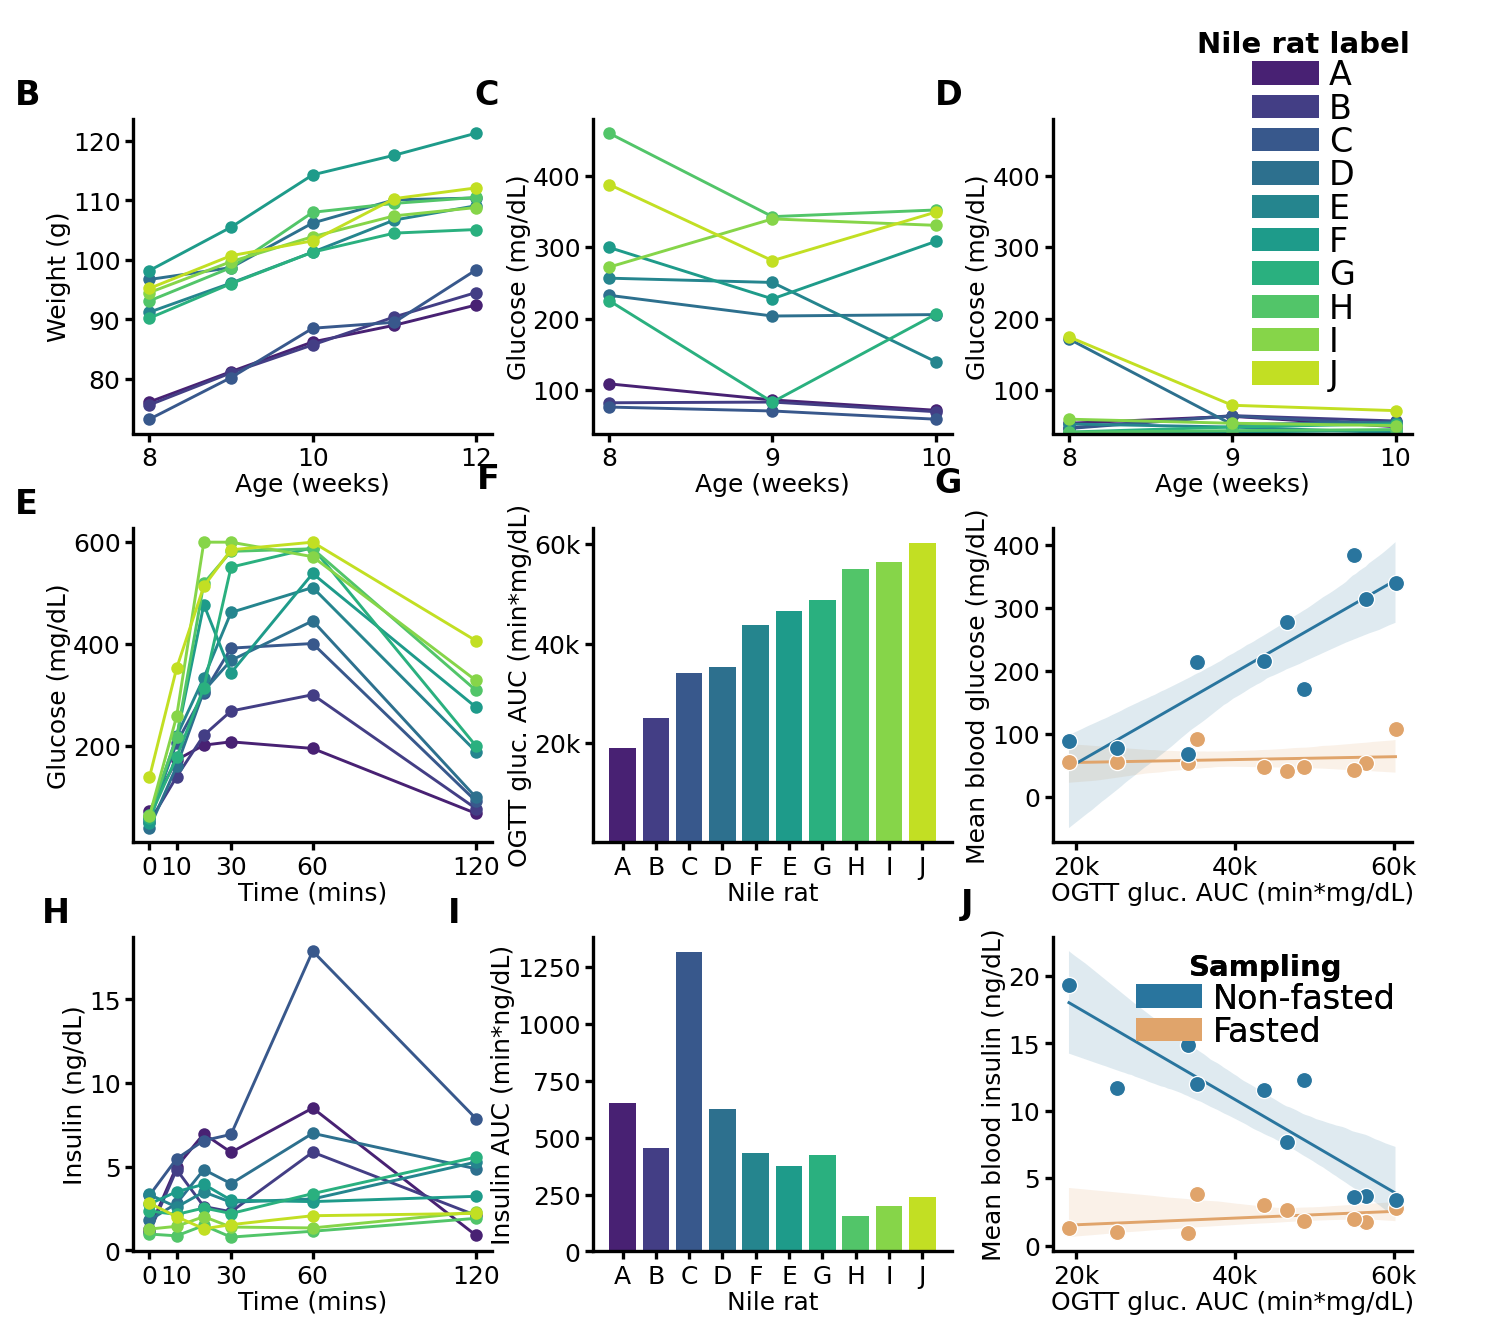

In [21]:
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 0.5

nrows, ncols = 3, 3
fig, a = plt.subplots(nrows=nrows, ncols=ncols, 
                      gridspec_kw={'hspace': 0.3, 'wspace': 0.28}, figsize=(5.5, 5), dpi=300)
a = a.ravel()
ms = 3
mec = '0.15'
mew = 0
lw = 0.7

### B ### Bodyweight
ax = a[0]
sns.lineplot(
    data=dfs['weight'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew, 
    legend=False, ax=ax)
ax.set_xlabel('Age (weeks)')
ax.set_ylabel('Weight (g)')

### C ### Nonfasted BG
ax = a[1]
sns.lineplot(
    data=dfs['RBG'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew, 
    legend=False, ax=ax)
ax.set_xticks([8, 9, 10])
ax.set_xlabel('Age (weeks)')
ax.set_ylabel('Glucose (mg/dL)')

### D ### Fasted BG
ax = a[2]
sns.lineplot(
    data=dfs['FBG'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew, 
    legend=False, ax=ax)
ax.set_xticks([8, 9, 10])
ax.set_xlabel('Age (weeks)')
ax.set_ylabel('Glucose (mg/dL)')
ax.set_ylim(a[1].get_ylim())


### E ###  OGTT glucose Curves
ax = a[3]
sns.lineplot(
    data=dfs['OGTT'], x='x', y='y', ax=ax,
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew, 
    legend=False)
ax.set_xticks(ticks=[0, 10, 30, 60, 120])
ax.set_xlabel('Time (mins)')
ax.set_ylabel('Glucose (mg/dL)')

### F ###  OGTT glucose AUC
ax = a[4]
ax.bar(x=bar_data['loc'], height=bar_data['OGTT (AUC)'], color=bar_data['color'].to_list())
# for loc, ogtt in zip(bar_data['loc'], bar_data['OGTT (AUC)']):
#     ax.annotate(str(int(round(ogtt, -3)))[:2] + 'k', xy=(loc, ogtt+1100), ha='center', zorder=9)
ax.set_xticks(ticks=range(10), labels=[x for x in 'ABCDFEGHIJ'])
ax.set_xlabel('Nile rat')
ax.set_yticks(ticks=[20000, 40000, 60000], labels=['20k', '40k', '60k'])
ax.set_ylabel('OGTT gluc. AUC (min*mg/dL)') 

### G ### INSULIN OGTT CURVE
ax = a[6]
sns.lineplot(
    data=dfs['ITT'], x='x', y='y',
    hue='ogtt_rank', palette=ogtt_rank_colors, marker='o', 
    markersize=ms, linewidth=lw, markeredgecolor=mec, markeredgewidth=mew,     
    legend=False, ax=ax)
ax.set_xticks(ticks=[0, 10, 30, 60, 120])
ax.set_xlabel('Time (mins)')
ax.set_ylabel('Insulin (ng/dL)')

### H ###  INSULIN AUC BAR
ax = a[7]
ax.bar(x=bar_data['loc'], height=bar_data['Insulin (AUC)'], color=bar_data['color'].to_list(),)
# for loc, ogtt in zip(bar_data['loc'], bar_data['Insulin (AUC)']):
#     ax.annotate(str(int(round(ogtt, 0))), xy=(loc, ogtt+50), ha='center', zorder=9)
ax.set_xticks(ticks=range(10), labels=[x for x in 'ABCDFEGHIJ'])
ax.set_xlabel('Nile rat')
ax.set_ylabel('Insulin AUC (min*ng/dL)')

### G ###
ax = a[5]
df = dfs['RBG'].groupby('animal').mean()
df = df.join(dfs['FBG'].groupby('animal').mean(), lsuffix='R', rsuffix='F')
df['animal_str'] = df.index.astype('str')
df = df.join(ap['OGTT (AUC)'])
sns.regplot(data=df, x='OGTT (AUC)', y='yF', ax=ax, color=colors['FBG'], scatter=False, 
            line_kws=dict(linewidth=lw), label='Fasted insulin')
sns.regplot(data=df, x='OGTT (AUC)', y='yR', ax=ax, color=colors['RBG'], scatter=False, 
            line_kws=dict(linewidth=lw), label='Nonfasted insulin')
sns.scatterplot(data=df, x='OGTT (AUC)', y='yF', s=ms*5, linewidths=0.8, ax=ax, 
                color=colors['FBG'], legend=False, zorder=2, edgecolors=colors['FBG'])
sns.scatterplot(data=df, x='OGTT (AUC)', y='yR', s=ms*5, linewidths=0.8, ax=ax, 
                color=colors['RBG'], legend=False, zorder=2, edgecolors=colors['RBG'])
ax.set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'])
ax.set_xlabel('OGTT gluc. AUC (min*mg/dL)')
ax.set_ylabel('Mean blood glucose (mg/dL)')

### J ###
ax = a[8]
df = dfs['Rinsulin'].groupby('animal').mean()
df = df.join(dfs['Finsulin'].groupby('animal').mean(), lsuffix='R', rsuffix='F')
df['animal_str'] = df.index.astype('str')
df = df.join(ap['OGTT (AUC)'])
sns.regplot(data=df, x='OGTT (AUC)', y='yF', ax=ax, color=colors['FBG'], scatter=False, 
            line_kws=dict(linewidth=lw), label='Fasted insulin')
sns.regplot(data=df, x='OGTT (AUC)', y='yR', ax=ax, color=colors['RBG'], scatter=False, 
            line_kws=dict(linewidth=lw), label='Nonfasted insulin')
sns.scatterplot(data=df, x='OGTT (AUC)', y='yF', s=ms*5, linewidths=0.8, ax=ax, 
                color=colors['FBG'], legend=False, zorder=2, edgecolors=colors['FBG'])
sns.scatterplot(data=df, x='OGTT (AUC)', y='yR', s=ms*5, linewidths=0.8, ax=ax, 
                color=colors['RBG'], legend=False, zorder=2, edgecolors=colors['RBG'])
ax.set_xticks([20000, 40000, 60000], ['20k', '40k', '60k'])
ax.set_xlabel('OGTT gluc. AUC (min*mg/dL)')
ax.set_ylabel('Mean blood insulin (ng/dL)')


# a[-1][-1].remove()  # Remove the empty plot

legend = plt.legend(handles=[patches.Patch(facecolor=colors['RBG'], edgecolor='none', linewidth=0, label='Non-fasted'),
                     patches.Patch(facecolor=colors['FBG'], edgecolor='none', linewidth=0, label='Fasted')],
                    title='Sampling', title_fontproperties={'weight': 'semibold', 'size': 7}, 
                    labelspacing=0.01, handletextpad=0.3)
a[-1].add_artist(legend)

legend_patches = []
for color, label in zip(cmap, 'ABCDEFGHIJ'):
    legend_patches.append(patches.Patch(facecolor=color, edgecolor='none', linewidth=0, label=label))
fig.legend(handles=legend_patches, loc=(0.8, 0.7), 
           title='Nile rat label',  title_fontproperties={'weight': 'semibold', 'size': 7},
           markerscale=1.5, labelspacing=0.01, handletextpad=0.3)

for ax, letter in zip(a, 'BCDEFGHIJK'):
    bb = tight_bbox(ax)
    ax.text(x=bb.x0, y=bb.y1+0.01, s=letter, transform=fig.transFigure, fontweight='bold', fontsize=8)
#     ax.annotate(letter, xy=(-0.25, 1.05), xycoords='axes fraction', fontsize=25, fontweight='bold')
#     ax.tick_params(labelsize=14)
for ax in a: 
    for pos in ax.spines:
        ax.spines[pos].set_linewidth(0.8)
    ax.tick_params(labelsize=6)
sns.despine()
# plt.tight_layout()
plt.savefig(r'..\reports\figures\Figure1\all_phenotypes.pdf', bbox_inches='tight', dpi=300, facecolor='white')
# plt.savefig(r'..\reports\figures\0-1-1\all_phenotypes.png', bbox_inches='tight', dpi=100, facecolor='white')
plt.savefig(r'..\reports\figures\Figure1\all_phenotypes.svg', bbox_inches='tight', dpi=300, facecolor='white')


In [43]:
test = (ap
        .loc[ap['lcms_sampled'], ['RBGweek8', 'RBGweek9', 'RBGweek10', 'RBGweek11']]
#         .filter(regex='^RBGweek')
#         .mean(axis=1).to_frame()
        .join(ap['OGTT (AUC)'])
        .reset_index()
       )
test = test.melt(id_vars=['animal', 'OGTT (AUC)']).dropna()
test

,animal,OGTT (AUC),variable,value
0,1060,48742.5,RBGweek8,225.000000
1,1062,43717.5,RBGweek8,256.500000
2,1074,35250.0,RBGweek8,232.500000
3,1076,60245.0,RBGweek8,387.666667
4,1082,56462.5,RBGweek8,272.000000
5,1091,19060.0,RBGweek8,108.500000
6,1092,34022.5,RBGweek8,76.000000
7,1093,25057.5,RBGweek8,82.000000
8,1101,55007.5,RBGweek8,459.500000
9,1102,46565.0,RBGweek8,299.500000


<AxesSubplot:xlabel='OGTT (AUC)', ylabel='value'>

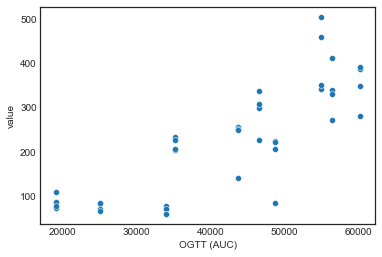

In [44]:
sns.scatterplot(
    data=test, x='OGTT (AUC)', y='value'
)

# show random-fed blood glucoses over time for validation 30wk rats

In [17]:
animals = ap.loc[ap['validation'] & (ap['OGTT_age'].notna()) & (ap['cohort'] == '30wk')].index
animals

Int64Index([1727, 1728, 1731, 1732, 1735, 1741, 1746, 1748, 1742, 1743, 1754], dtype='int64', name='animal')

In [21]:
df = ap.filter(regex='^RBGweek').iloc[:, 6:].loc[animals]
df.columns = [int(x[-2:]) for x in df.columns]
df

,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
animal,,,,,,,,,,,,,,,
1727,185.0,129.0,122.0,262.0,278.5,229.0,222.0,198.5,180.0,182.0,221.0,315.0,NaN,NaN,NaN
1728,76.0,212.0,224.0,223.0,241.0,241.0,215.0,294.0,278.5,229.5,276.0,353.0,NaN,NaN,NaN
1731,94.0,78.0,124.0,102.0,88.0,80.0,74.0,76.0,82.0,78.0,113.0,97.5,67.0,127.0,87.5
1732,NaN,NaN,NaN,NaN,75.5,68.0,90.0,64.0,79.0,88.0,96.0,210.0,NaN,NaN,NaN
1735,69.0,67.0,76.0,72.0,96.0,63.0,84.0,83.0,86.0,81.0,107.0,99.5,176.0,224.5,NaN
1741,64.0,69.0,79.5,68.5,84.5,78.0,88.0,94.0,142.0,155.0,243.0,NaN,NaN,NaN,NaN
1746,69.0,75.0,97.5,80.0,81.0,92.0,81.0,60.0,73.0,107.0,84.0,114.0,193.0,105.0,116.0
1748,88.0,73.0,100.0,82.0,92.0,72.0,83.0,72.0,59.0,81.0,74.0,149.0,218.0,246.5,NaN
1742,66.0,102.0,89.0,88.5,82.0,83.0,61.0,89.0,86.0,71.0,91.0,NaN,NaN,NaN,NaN


In [ ]:
pd.DataFrame.reset_index

In [88]:
new = []
for animal in animals:
    row = df.loc[animal]
    age = ap.loc[animal, 'OGTT_age']
#     print(age)
    weeks_b4_ogtt = [idx - age for idx in row.index]
    row.index = weeks_b4_ogtt
#     display(row)
    new.append(row)
wkdf = pd.DataFrame(new).iloc[:, 1:-3]
wkdf['animal'] = wkdf.index
# wkdf = wkdf.join(ap['sex'])
wkdf
wkdf = wkdf.melt(id_vars='animal', value_vars=wkdf.columns[:-1], 
                 var_name='week', value_name='rbg')
wkdf = wkdf.join(ap['sex'], on='animal' )
wkdf = wkdf.loc[wkdf['week'] > -11 ]
wkdf

,animal,week,rbg,sex
55,1727,-10.0,129.0,M
56,1728,-10.0,212.0,M
57,1731,-10.0,88.0,F
58,1732,-10.0,NaN,M
59,1735,-10.0,72.0,M
...,...,...,...,...
171,1746,0.0,116.0,F
172,1748,0.0,246.5,F
173,1742,0.0,NaN,F
174,1743,0.0,NaN,F


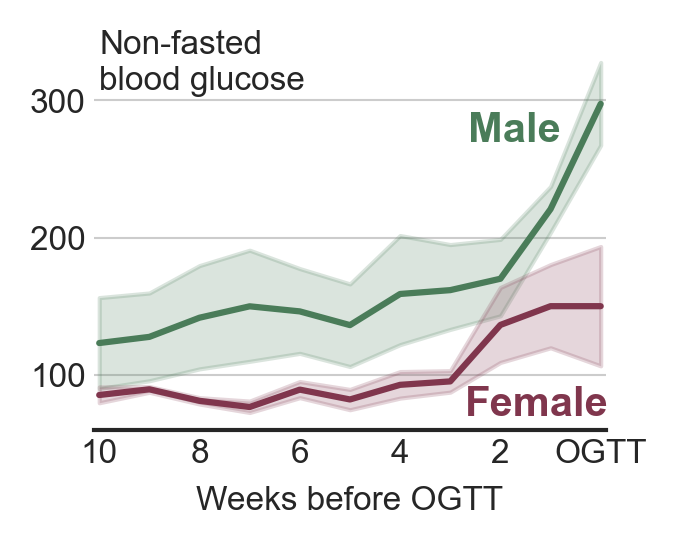

In [169]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))

f = np.array([111, 29, 27])/256  # brick red
f = np.array([129, 54, 101])/256  # light burgundy
f = np.array([247, 175, 157])/256 # coral
f = np.array([225, 165, 107])/256 # muted orange
f = np.array([87, 167, 115])/256 # green
# m = np.array([43, 45, 66])/256  # dark gray-brown
# m = np.array([33, 37, 41])/256  # dark blue-gray
# f = np.array([141, 153, 174])/256
# m = np.array([21, 97, 109])/256 # dark teal
m = np.array([41, 117, 159])/256 # cobalt
mf = {'M': m, 'F': f}

fig, ax = plt.subplots(dpi=300, figsize=(2.2, 1.7))
sns.lineplot(
    data=wkdf, x='week', y='rbg', ax=ax,
    hue='sex', palette=colors, 
    ci=68, n_boot=200, seed=1,
    legend=False,
)
# ax.set_ylabel('Non-fasted\nblood glucose', fontsize=8)
ax.set_ylabel(None)
ax.text(-10, 308, 'Non-fasted\nblood glucose', fontsize=8)
ax.set_xlabel('Weeks before OGTT', fontsize=8)
ax.tick_params(pad=2, length=0, labelsize=8)
ax.set_xticks(np.arange(-10, 2, 2), labels=[str(x) for x in np.arange(10, 0, -2)] + ['OGTT'])
# ax.set_title('30 week Nile rats blood glucose')
# plt.title("This is title number: " + r"\textbf{" + str(number) + "}")
ax.text(-2.65, 270, r'Male', color=colors['M'], fontweight='bold', fontsize=10)
ax.text(-2.7, 70, 'Female', color=colors['F'], fontweight='bold', fontsize=10)
ax.set_axisbelow(True)
ax.grid(axis='y', lw=0.5, ls='-', color='0.8')
ax.spines['bottom'].set_linewidth(1)
ax.set_xmargin(0.01)
sns.despine(left=True)

plt.savefig('../reports/figures/Figure7/RBGs_before_OGTT.pdf', bbox_inches='tight')

<AxesSubplot:xlabel='ogtt', ylabel='quant'>

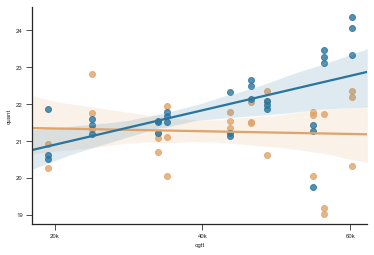

In [168]:
plot_quant_vs_ogtt('l_777')